In [1]:
import numpy as np
import pandas as pd
import os
import pathlib

# data viz
from matplotlib import pyplot as plt
import seaborn as sns           # for nicer plots
sns.set(style="darkgrid")       # default style

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# tf
import tensorflow as tf
from tensorflow.keras import initializers

# Step 1: Data Ingestion

Available at `02-choose-trgt-and-preprocess-imputemeansubgr-imbalance-sa.ipynb` notebook

# Step 2: Data Preprocessing

Available at `02-choose-trgt-and-preprocess-imputemeansubgr-imbalance-sa.ipynb` notebook

# Step 3: Exploratory Data Analysis

EDA of balanced data is available at `03-eda-imputemeansubgr-smotenc-sa.ipynb` notebook

# Step 4: Consider Feature Selection

Exploration of feature selection using pearson correlation and feature importance are available in `04-feature-select-imputemeansubgr-smontenc-sa.ipynb` notebook. Since we have over 51,500 samples to feature ratio, we will use all features from Step 2 in model building.

# Step 5: Modeling (FFNN)

`load preprocessed data`

In [2]:
DATA_PATH = '../data/processed/'
FILE_NAME = 'fpafod_imb_scaled.npz'

fpafod = np.load(DATA_PATH+FILE_NAME)

X_train_std = fpafod['X_train_std']
Y_train = fpafod['Y_train']
X_val_std = fpafod['X_val_std']
Y_val = fpafod['Y_val']
X_test_std = fpafod['X_test_std']
Y_test = fpafod['Y_test']

print(f"\nShape of X_train: {X_train_std.shape}")
print(f"Shape of X_val: {X_val_std.shape}")
print(f"Shape of X_test: {X_test_std.shape}")

print(f"\nShape of Y_train: {Y_train.shape}")
print(f"Shape of Y_val: {Y_val.shape}")
print(f"Shape of Y_test: {Y_test.shape}")


Shape of X_train: (1381512, 104)
Shape of X_val: (460504, 104)
Shape of X_test: (460505, 104)

Shape of Y_train: (1381512,)
Shape of Y_val: (460504,)
Shape of Y_test: (460505,)


#### Prepare functions

In [3]:
def build_model_ffnn(n_classes,
                n_features,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01,
                dropout_rate = 0.2,
                metric='metric'):
    """Build a FFNN model using Keras.
    
    Args:
    - n_classes: Number of output classes in the dataset.
    - n_features: Number of features in the dataset.
    - hidden_layer_sizes: A list with the number of units in each hidden layer.
    - activation: The activation function to use for the hidden layers.
    - optimizer: The optimizer to use (SGD, Adam).
    - learning_rate: The desired learning rate for the optimizer.
    - metric: The desired metric.

    Returns:
    model: A tf.keras model.
    """
    tf.keras.backend.clear_session()
    np.random.seed(207)
    tf.random.set_seed(207)

    model = tf.keras.Sequential()

    # first layer: input
    model.add(tf.keras.layers.Input(shape=[n_features], name='Input'))

    # hidden and dropout layers
    for idx, hidden_layer_sizes in enumerate(hidden_layer_sizes):
        model.add(tf.keras.layers.Dense(units=hidden_layer_sizes,
                                        activation=activation,
                                        name='Hidden_'+str(idx)))    
        model.add(tf.keras.layers.Dropout(rate=dropout_rate, name='Dropout_'+str(idx)))      # dropout layer
        
    # output layer
    model.add(tf.keras.layers.Dense(units=n_classes,
                                    use_bias=True,
                                    activation='softmax',
                                    # bias_initializer=tf.ones_initializer,
                                    # kernel_initializer=initializers.GlorotNormal(seed=207),
                                    name='Output'))
    
    # choose optimizer
    if optimizer=='SGD':
        chosen_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer=='Adam':
        chosen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise 'Unsupported optimizer: %s' %optimizer
    
    # compile model
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = chosen_optimizer,
        metrics = metric
    )

    return model

In [4]:
num_classes = 4
Y_train_oh = tf.keras.utils.to_categorical(Y_train, num_classes=num_classes)
Y_val_oh   = tf.keras.utils.to_categorical(Y_val,   num_classes=num_classes)

In [5]:
def plot_history_metrics(history):
    """Plot history metrics for training and validation data"""
    metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'prc']

    fig = plt.figure(figsize=(10,11))
    
    for i, name in enumerate(metric_names):
        val_name = f"val_{name}"
        train_hist = history.history[name]
        val_hist = history.history[val_name]

        ax = fig.add_subplot(3,2,i+1)
        plt.plot(train_hist, label='Train')
        plt.plot(val_hist, label='Val')
        plt.legend()
        ax.set_xlabel('Epochs')
        ax.set_title(name.capitalize())
    
    plt.tight_layout()
    plt.show()

In [6]:
def print_last_epoch_metrics(history):
    metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'prc']
    for i, name in enumerate(metric_names):
        val_name = f"val_{name}"
        train_hist = history.history[name]
        val_hist = history.history[val_name]
        print(f"---- Last epoch {name} ----")
        print(f"* Training: {train_hist[-1]: .3f}")
        print(f"* Validation: {val_hist[-1]: .3f}\n")

In [7]:
METRICS = ['accuracy', tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.F1Score(average='macro', name='f1_score'),
           tf.keras.metrics.AUC(name='prc', curve='PR')]

def train_and_evaluate_ffnn(data='wildfire',
                       n_features = X_train_std.shape[1],
                       hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric=METRICS,
                       batch_size = 4096,
                       dropout_rate = 0.2,
                       num_epochs=5):

  # Build the model.
    model = build_model_ffnn(n_classes=4,
                        n_features = n_features,
                        hidden_layer_sizes=hidden_layer_sizes,
                        activation=activation,
                        optimizer=optimizer,
                        metric=metric,
                        learning_rate=learning_rate,
                        dropout_rate=dropout_rate)

  # Select the dataset.
    if data == 'wildfire':
        pass
    
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model.
    print('Training the', data, 'model...')
    history = model.fit(
        x=X_train_std,
        y=Y_train_oh,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=[X_val_std, Y_val_oh],
        verbose=0)
    
    # Plot history
    plot_history_metrics(history)

    # Print last epoch metrics
    print_last_epoch_metrics(history)

    return model


#### Train Model

Training the wildfire model...


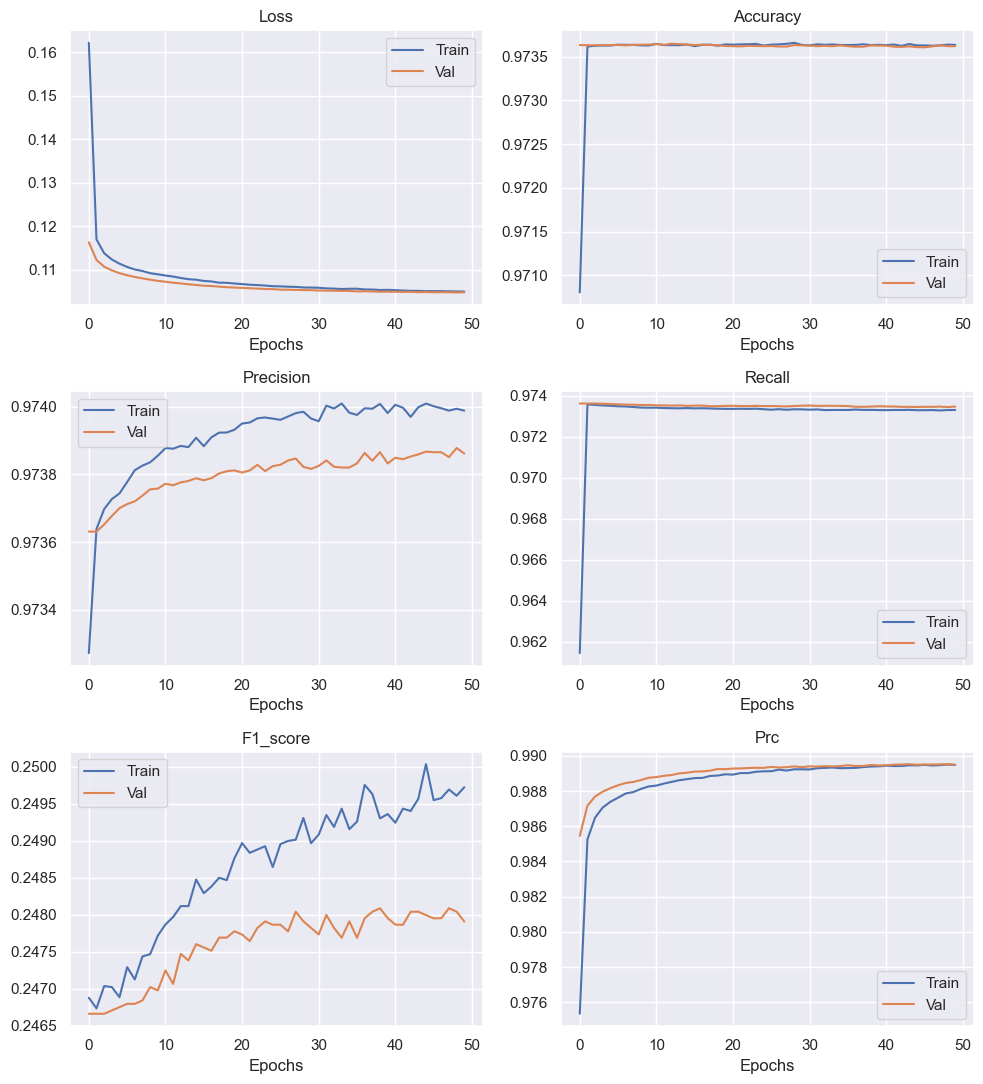

---- Last epoch loss ----
* Training:  0.105
* Validation:  0.105

---- Last epoch accuracy ----
* Training:  0.974
* Validation:  0.974

---- Last epoch precision ----
* Training:  0.974
* Validation:  0.974

---- Last epoch recall ----
* Training:  0.973
* Validation:  0.973

---- Last epoch f1_score ----
* Training:  0.250
* Validation:  0.248

---- Last epoch prc ----
* Training:  0.989
* Validation:  0.989



In [8]:
# conduct experiments and record results in an ablation table
model_exp = train_and_evaluate_ffnn(hidden_layer_sizes=[64],
                                    dropout_rate=0.1,
                                    learning_rate=0.001,
                                    batch_size=4096,
                                    num_epochs=50)

In [9]:
model_exp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_0 (Dense)                │ (None, 64)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_0 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,942 (81.81 KB)

 Trainable params: 6,980 (27.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,962 (54.54 KB)

In [10]:
# report the hyperparameter values for the prefered architecture configuration

print("""The hyperparameter values for prefered architecture configuration are:
      - hidden sizes: [64]
      - activation: relu
      - optimizer: Adam
      - learning rate: 0.001
      - number of epochs: 50
      - dropout rate: 0.05
      - batch_size: 2048
""")

The hyperparameter values for prefered architecture configuration are:
      - hidden sizes: [64]
      - activation: relu
      - optimizer: Adam
      - learning rate: 0.001
      - number of epochs: 50
      - dropout rate: 0.05
      - batch_size: 2048



In [11]:
# run the model once more using the preferred hyperparameter configuration

# define parameters
n_features = X_train_std.shape[1]
hidden_layer_sizes_preferred = [64]
activation_preferred = 'relu'
optimizer_preferred = 'Adam'
dropout_rate_preferred = 0.05
learning_rate_preferred = 0.001
num_epochs_preferred = 50
batch_size_preferred = 2048

# run the model
model_tf = build_model_ffnn(n_classes=4,
                        n_features = n_features,
                        hidden_layer_sizes=hidden_layer_sizes_preferred,
                        activation=activation_preferred,
                        optimizer=optimizer_preferred,
                        dropout_rate= dropout_rate_preferred,
                        metric=METRICS,
                        learning_rate=learning_rate_preferred)

model_fit_tf = model_tf.fit(x=X_train_std,
        y=Y_train_oh,
        epochs=num_epochs_preferred,
        batch_size=batch_size_preferred,
        validation_data=[X_val_std, Y_val_oh],
        verbose=0)

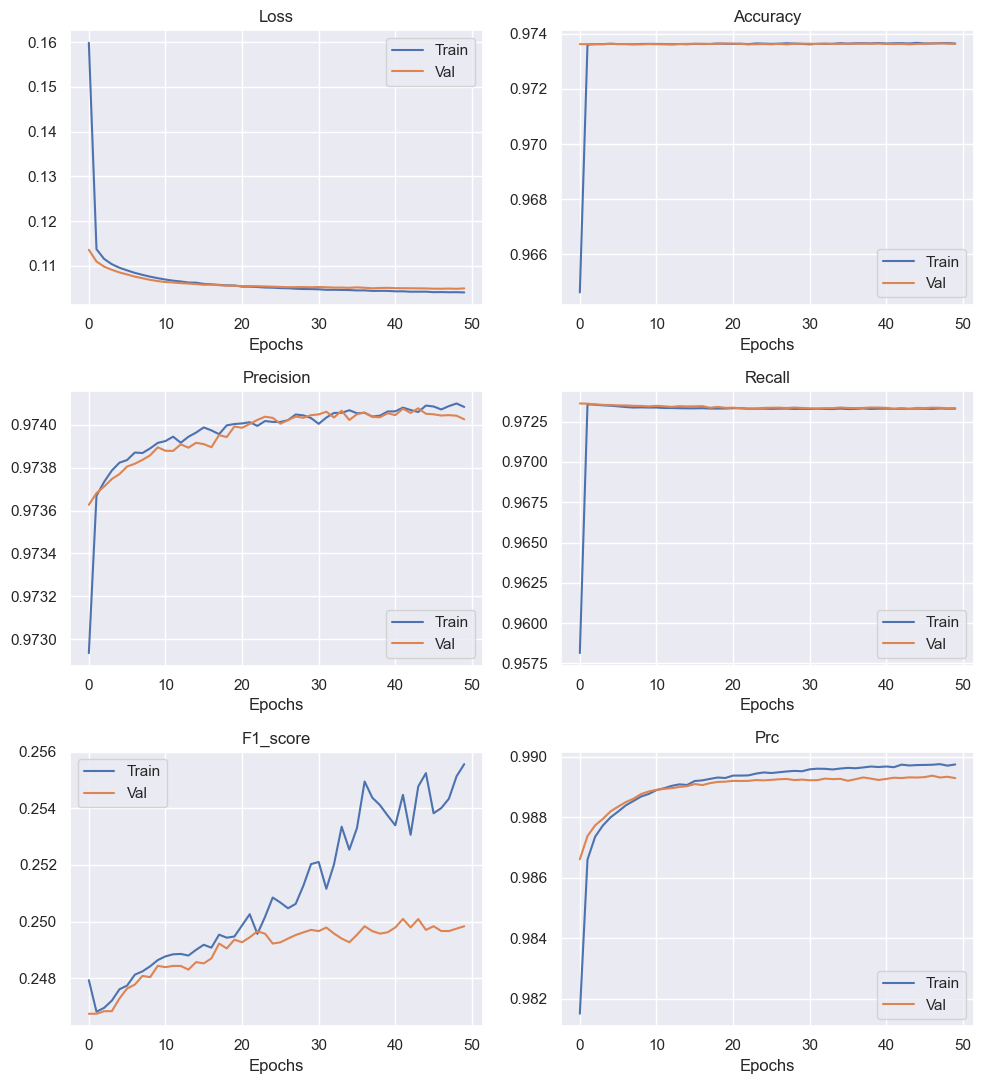

In [12]:
# plot history metrics
plot_history_metrics(model_fit_tf)

## Evaluate

In [13]:
Y_val_pred_proba = model_tf.predict(X_val_std) # predicted probability 
Y_val_pred = np.argmax(Y_val_pred_proba, axis=1)

print(f"Shape of Y_val: {Y_val.shape}")
print(f"Shape of Y_val_pred: {Y_val_pred.shape}")

14391/14391 ━━━━━━━━━━━━━━━━━━━━ 3s 238us/step
Shape of Y_val: (460504,)
Shape of Y_val_pred: (460504,)


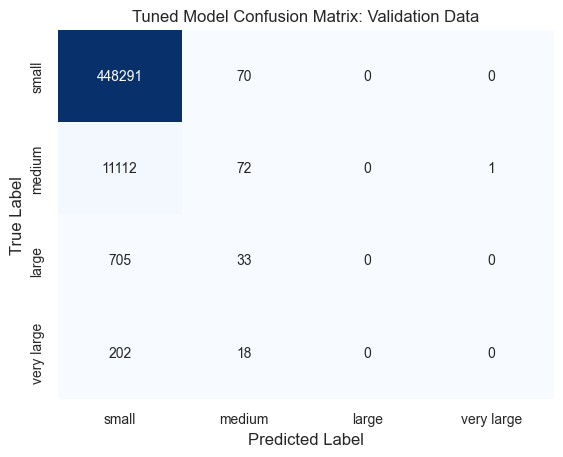

In [14]:
# plot the confusion matrix using (y_val, y_val_pred) data
target_labels = ['small', 'medium', 'large', 'very large']          

cf = tf.math.confusion_matrix(Y_val, Y_val_pred)
ax = sns.heatmap(cf, annot=True, fmt='d', cmap='Blues',
                 cbar=False,
                 annot_kws={'fontsize': 10},
                 xticklabels=target_labels,
                 yticklabels=target_labels)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel='Predicted Label', ylabel='True Label')
ax.set_title('Tuned Model Confusion Matrix: Validation Data')
plt.show()

In [15]:
def print_report(fitted_clf, X, Y, txt = 'Data', threshold=[0,0,0,0]):
    target_labels = ['small', 'medium', 'large', 'very large']
    Y_pred_proba = fitted_clf.predict(X)
    Y_pred = np.argmax(Y_pred_proba - threshold, axis=1)
    print(f"\n*** {txt} ***")
    print(classification_report(Y, Y_pred, target_names=target_labels, digits=5))

In [16]:
print_report(model_tf, X=X_train_std, Y=Y_train, txt="FFNN (Training Data)")
print_report(model_tf, X=X_val_std, Y=Y_val, txt="FFNN (Validation Data)")

43173/43173 ━━━━━━━━━━━━━━━━━━━━ 10s 233us/step

*** FFNN (Training Data) ***
              precision    recall  f1-score   support

       small    0.97390   0.99985   0.98670   1345082
      medium    0.43508   0.00769   0.01511     33560
       large    1.00000   0.00136   0.00271      2210
  very large    0.75000   0.00455   0.00904       660

    accuracy                        0.97367   1381512
   macro avg    0.78974   0.25336   0.25339   1381512
weighted avg    0.96075   0.97367   0.96106   1381512

14391/14391 ━━━━━━━━━━━━━━━━━━━━ 3s 231us/step

*** FFNN (Validation Data) ***
              precision    recall  f1-score   support

       small    0.97389   0.99984   0.98670    448361
      medium    0.37306   0.00644   0.01266     11185
       large    0.00000   0.00000   0.00000       738
  very large    0.00000   0.00000   0.00000       220

    accuracy                        0.97364    460504
   macro avg    0.33674   0.25157   0.24984    460504
weighted avg    0.95727   0.

/Users/shantiagung/Documents/mids/mids-w207-section1-team1-finalproject/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shantiagung/Documents/mids/mids-w207-section1-team1-finalproject/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shantiagung/Documents/mids/mids-w207-section1-team1-finalproject/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels